In [23]:
import numpy as np
import pandas as pd

from gtda.time_series import SlidingWindow
from gtda.diagrams import PersistenceLandscape
from gtda.homology import VietorisRipsPersistence

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.set_option('display.max_columns', None)
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
# !pip install spectrum 
# from spectrum.periodogram import speriodogram

import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess

In [2]:
# Functions to compute the Lp norms
# Find the range of x values from the persistence diagram:
def Ftseq(diagram):
    births =[]
    deaths =[]
    for pair in diagram:
        if pair[2] == 1:
            births.append(pair[0])
            deaths.append(pair[1])
    return np.linspace(min(births), max(deaths), 100)

# Calculate Lp norm:
def Lpnorm(tseq, landscapevalues, p = 1):
    norms = []
    if p.lower() == 'auc':
        for point in zip(tseq,landscapevalues):
            norms.append(np.trapz(landscapevalues, tseq))
    else: 
        for point in zip(tseq,landscapevalues):
            norms.append(np.linalg.norm(point, p))        
    return sum(norms)

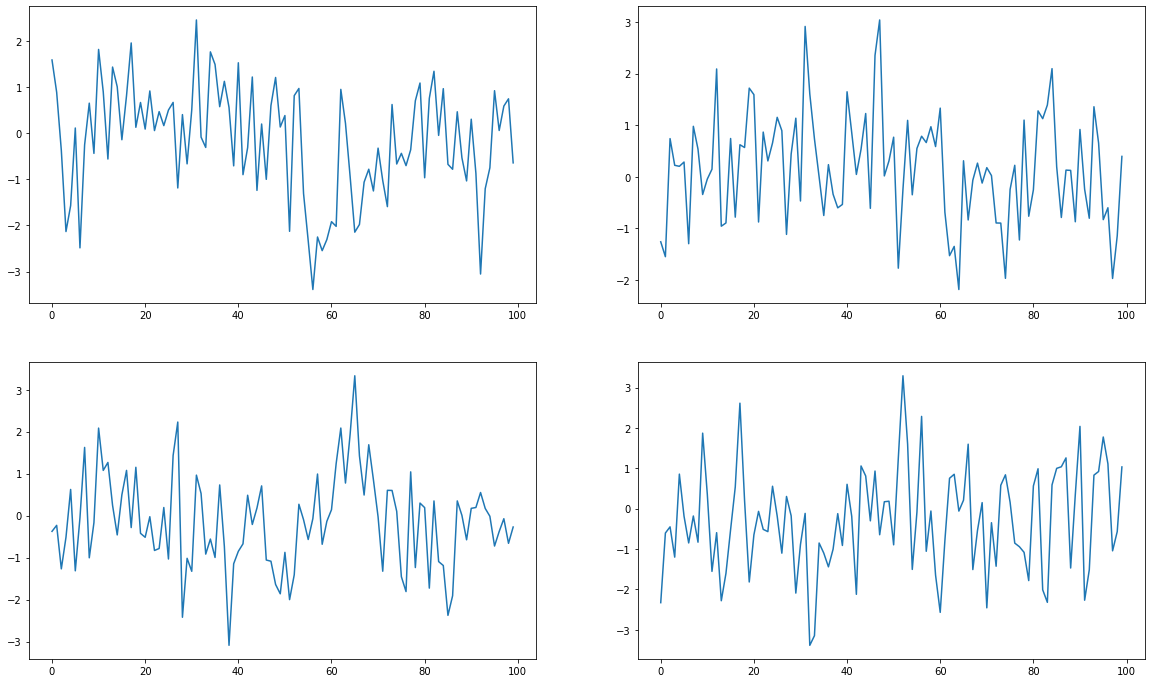

In [3]:
ar = np.array([1,.4])
ma = np.array([1,.8,.2,.3])
AR_object = ArmaProcess(ar, ma)

simulated_data1 = AR_object.generate_sample(nsample=100, scale = 1 + np.random.uniform(-.1,.1))
simulated_data2 = AR_object.generate_sample(nsample=100, scale = 1 + np.random.uniform(-.1,.1))
simulated_data3 = AR_object.generate_sample(nsample=100, scale = 1 + np.random.uniform(-.1,.1))
simulated_data4 = AR_object.generate_sample(nsample=100, scale = 1 + np.random.uniform(-.1,.1))
plt.figure(figsize = (20,12))
plt.subplot(2,2,1)
plt.plot(simulated_data1)
plt.subplot(2,2,2)
plt.plot(simulated_data2)
plt.subplot(2,2,3)
plt.plot(simulated_data3)
plt.subplot(2,2,4)
plt.plot(simulated_data4)
plt.show()

In [4]:
simulated_data = pd.DataFrame(simulated_data1, columns = ['1'])
simulated_data = simulated_data.join(pd.DataFrame(simulated_data2, columns = ['2']))
simulated_data = simulated_data.join(pd.DataFrame(simulated_data3, columns = ['3']))
simulated_data = simulated_data.join(pd.DataFrame(simulated_data4, columns = ['4']))
simulated_data

,1,2,3,4
0,1.593456,-1.258261,-0.373977,-2.327886
1,0.891724,-1.546977,-0.230628,-0.602616
2,-0.369193,0.742285,-1.267732,-0.449396
3,-2.131508,0.224678,-0.514317,-1.199539
4,-1.567713,0.205128,0.625074,0.857462
...,...,...,...,...
95,0.926611,-0.828756,-0.723606,1.776875
96,0.063045,-0.598373,-0.376852,1.112528
97,0.592938,-1.969181,-0.072459,-1.043250
98,0.750393,-1.141188,-0.658844,-0.566635


In [5]:
dataPct = simulated_data.pct_change()
dataPct = simulated_data.dropna()
dataPct

,1,2,3,4
0,1.593456,-1.258261,-0.373977,-2.327886
1,0.891724,-1.546977,-0.230628,-0.602616
2,-0.369193,0.742285,-1.267732,-0.449396
3,-2.131508,0.224678,-0.514317,-1.199539
4,-1.567713,0.205128,0.625074,0.857462
...,...,...,...,...
95,0.926611,-0.828756,-0.723606,1.776875
96,0.063045,-0.598373,-0.376852,1.112528
97,0.592938,-1.969181,-0.072459,-1.043250
98,0.750393,-1.141188,-0.658844,-0.566635


In [7]:
fig = px.line(simulated_data,
              width=1000, height=700
              , title = 'Synthetic Data')
fig.show()

fig = px.line(dataPct,
              width=1000, height=700
              ,title = 'Percent Change')
fig.show()

<AxesSubplot:>

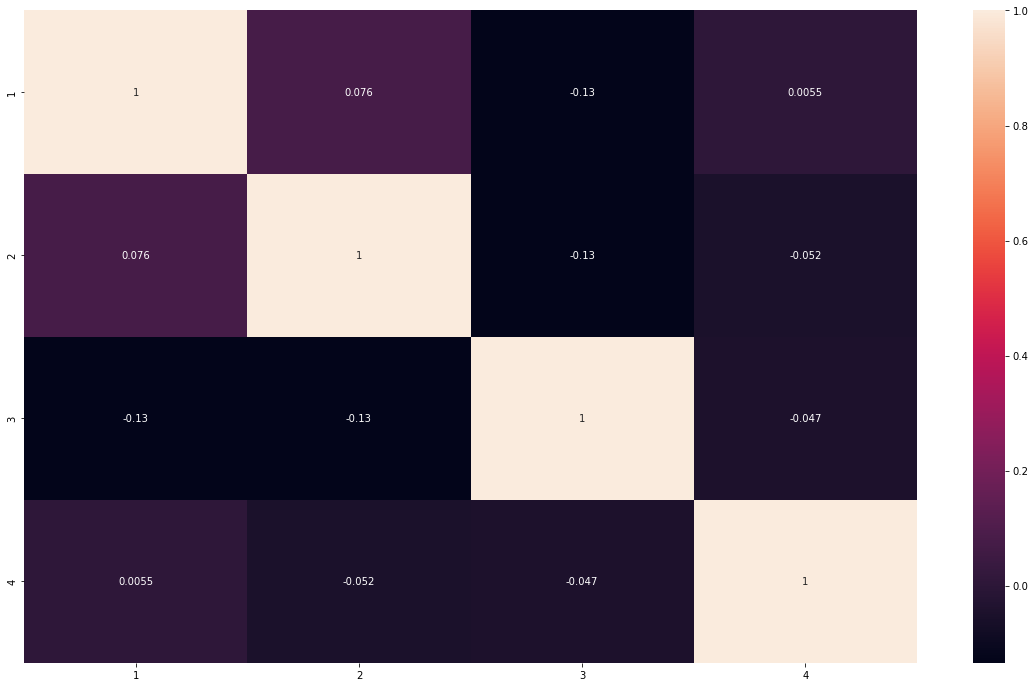

In [8]:
figure(figsize = (20,12))
sns.heatmap(simulated_data.corr(), annot = True)

In [9]:
# Create point cloud of size 60 and stride 1
window_size = 40
stride = 1
df = dataPct
X = df
y = df.index
SW = SlidingWindow(size=window_size, stride=stride)
X_sw, yr = SW.fit_transform_resample(X, y)

In [10]:
# Plot an arbitrary point cloud in 3D
win = 40
fig = px.scatter_3d(x = X_sw[win][:,0],
                    y = X_sw[win][:,1],
                    z = X_sw[win][:,2],
                    labels = {'x': 'GDP',
                              'y': 'CPI',
                              'z': 'Unemployment'},
                    width=1000, height=700,)
fig.show()

In [11]:
# Plot the persistence diagram and landscape for a random point cloud sliding window
from gtda.homology import VietorisRipsPersistence
pointcloud = X_sw[40]

vrp = VietorisRipsPersistence()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape))
plt.show()

pl = PersistenceLandscape()
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
pl.plot(landscapedata, homology_dimensions = [1], plotly_params=None)

In [14]:
# Calculate the norms for each of the windows in the multivariate sliding window

# Initialize empty list
Norms = np.empty(window_size)
Norms[:] = np.nan
Norms = list(Norms)
vrp = VietorisRipsPersistence()
pl = PersistenceLandscape()
for pointcloud in X_sw:
    persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
    landscapedata = pl.fit_transform(persistencediagram)
    tseq = Ftseq(persistencediagram[0])
    yvalues = landscapedata[0][1]
    Norms.append(Lpnorm(tseq, yvalues, p = 'auc'))
Norms

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 6.6830541029567305,
 6.188044147288537,
 6.188044147288537,
 6.188044147288537,
 6.207004822029829,
 7.241985770060298,
 6.569921100665795,
 6.002095633985334,
 6.002095633985334,
 7.750289417215121,
 7.607667110870863,
 5.218489261997392,
 5.218489261997392,
 5.2920674251832756,
 5.2920674251832756,
 4.491183940919728,
 4.491183940919728,
 6.034120334193192,
 6.382154072508212,
 7.326989684069308,
 7.326989684069308,
 7.300553223651012,
 7.967116922132771,
 7.489326073313495,
 7.489326073313495,
 6.644132406310993,
 6.644132406310993,
 9.098395528700292,
 10.12024911103555,
 10.12024911103555,
 6.888030061579256,
 9.891128897104977,
 9.66935416242071,
 9.66935416242071,
 10.03662003837036,
 8.319335592964514,
 8.319335592964514,
 8.177014962030874,

In [19]:
normsmeans = []
sigs = []
for sig in np.linspace(1,40):
    ar = np.array([1,.4])
    ma = np.array([1,.8,.2,.3])
    AR_object = ArmaProcess(ar, ma)

    simulated_data1 = AR_object.generate_sample(nsample=100, scale = sig + np.random.uniform(-.1,.1))
    simulated_data2 = AR_object.generate_sample(nsample=100, scale = sig + np.random.uniform(-.1,.1))
    simulated_data3 = AR_object.generate_sample(nsample=100, scale = sig + np.random.uniform(-.1,.1))
    simulated_data4 = AR_object.generate_sample(nsample=100, scale = sig + np.random.uniform(-.1,.1))

    simulated_data = pd.DataFrame(simulated_data1, columns = ['1'])
    simulated_data = simulated_data.join(pd.DataFrame(simulated_data2, columns = ['2']))
    simulated_data = simulated_data.join(pd.DataFrame(simulated_data3, columns = ['3']))
    simulated_data = simulated_data.join(pd.DataFrame(simulated_data4, columns = ['4']))

    dataPct = simulated_data.pct_change()
    dataPct = simulated_data.dropna()


    window_size = 40
    stride = 1
    df = dataPct
    X = df
    y = df.index
    SW = SlidingWindow(size=window_size, stride=stride)
    X_sw, yr = SW.fit_transform_resample(X, y)

    Norms = np.empty(window_size)
    Norms[:] = np.nan
    Norms = list(Norms)
    vrp = VietorisRipsPersistence()
    pl = PersistenceLandscape()
    for pointcloud in X_sw:
        persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
        landscapedata = pl.fit_transform(persistencediagram)
        tseq = Ftseq(persistencediagram[0])
        yvalues = landscapedata[0][1]
        Norms.append(Lpnorm(tseq, yvalues, p = 'auc'))
    
    normsmeans.append(pd.Series(Norms).mean())
    sigs.append(sig)

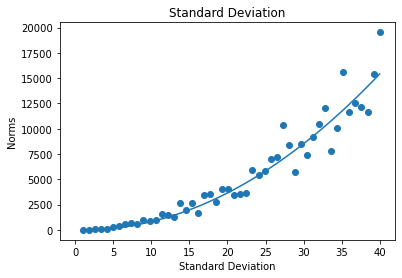

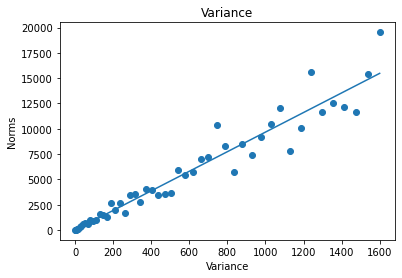

In [20]:
a,b,c = np.polyfit(sigs, normsmeans, 2)
plt.scatter(sigs, normsmeans)
plt.plot(sigs, a * np.array(sigs)**2 + b * np.array(sigs), + c)
plt.title('Standard Deviation')
plt.xlabel('Standard Deviation')
plt.ylabel('Norms')
plt.show()


variances = np.array(sigs)**2
a,b  = np.polyfit(variances, normsmeans, 1)
plt.scatter(variances, normsmeans)
plt.plot(variances, a * variances + b)
plt.title('Variance')
plt.xlabel('Variance')
plt.ylabel('Norms')
plt.show()